# Project Bird Vision 🐦 👁

🎯 The goal of this project is to build a model able to predict the breed of an image with more 95% accuracy.

For this project, I will import a dataset from TensorFlow Datasets. I will be able to use mixed precision training, these are good datasets and it handles downloading and preparing the data deterministically and constructing a `tf.data.Dataset` (or `np.array`).

## What I'm going to cover

* Using TensorFlow Datasets to download and explore data
* Creating preprocessing function for our data
<!-- * Batching & preparing datasets for modelling (**making our datasets run fast**) -->
* Creating modelling callbacks
<!-- * Setting up **mixed precision training** -->
* Building a feature extraction model
* Fine-tuning the feature extraction model
* Viewing training results on TensorBoard
* Evaluate predictions
* Viewing predictions on test images
* Viewing the most wrong predictions
* Viewing predictions on custom images

## Create helper functions

In [172]:
# Get our helper functions
with open("helper_functions.py", "r") as fichier:
    contenu = fichier.read()

In [3]:
!pip install tensorflow

     -------------------------------------- 272.8/272.8 MB 8.4 MB/s eta 0:00:00
     ---------------------------------------- 1.7/1.7 MB 108.0 MB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 47.6 MB/s eta 0:00:00
     ---------------------------------------- 4.1/4.1 MB 89.1 MB/s eta 0:00:00
     ---------------------------------------- 1.3/1.3 MB 84.5 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
     ------------------------------------- 440.7/440.7 kB 26.9 MB/s eta 0:00:00
     ---------------------------------------- 57.5/57.5 kB ? eta 0:00:00
     --------------------------------------- 14.7/14.7 MB 59.5 MB/s eta 0:00:00
  Using cached absl_py-1.4.0-py3-none-an

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.23.5 which is incompatible.


In [164]:
# Import series of helper functions for our notebook
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir, pred_and_plot, load_and_prep_image

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [ ]:
# Let's check birds datasets
tfds.list_builders()

We have two datasets available in TensorFlow Datasets:
* caltech_birds2010
* caltech_birds2011

If I check those on the tensorflow's website: https://www.tensorflow.org/datasets/catalog/caltech_birds2011?hl=fr we have the following description:
* Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos of 200 bird species (mostly North American). The total number of categories of birds is 200 and there are 6033 images in the 2010 dataset and 11,788 images in the 2011 dataset. Annotations include bounding boxes, segmentation labels.

We can see on the 2011 dataset, the number of images is twice as big as the 2010 one's. Because the bigger the sample is the higher the accuracy is, I will choose the second one `caltech_birds2011`.

Now, it is time to get our data in train and test set and see what they look like.

In [ ]:
# # Load train and test data.
# (test_data, train_data), ds_info = tfds.load(name="caltech_birds2011",
#                                     split=["test", "train"], # from the tensorflow's website, we can see there are only sets (train and test) with respectively 5794 and 5994 images.
#                                     shuffle_files=True,
#                                     as_supervised=True, # Because I work with labels
#                                     with_info=True) # I want to see what my data look like                                  

In [ ]:
# # Let's look at the features from the caltech_birds2011 dataset
# ds_info.features

## Dataset from kaggle

Unfortunatelly this dataset doesn't seem to let me to get labels, so I will use another set that I have on my drive.

On this dataset I have 510 breeds of birds.

In [16]:
# Create train and test dir
train_dir = "../Google Drive/Mon Drive/Birds/train"
test_dir = "../Google Drive/Mon Drive/Birds/test"

In [17]:
import tensorflow as tf
import random
import os

In [18]:
# Prepare databatch of 32 images for the training model
IMG_SIZE = (224, 224)
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode="categorical",
                                                                 image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) 

Found 80677 files belonging to 510 classes.
Found 2539 files belonging to 510 classes.


There are 80677 images to train our model.
There are 2539  images to test our model.

## Exploring our data

In [19]:
# Create the list of class
class_names = train_data.class_names
class_names[:10]

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS']

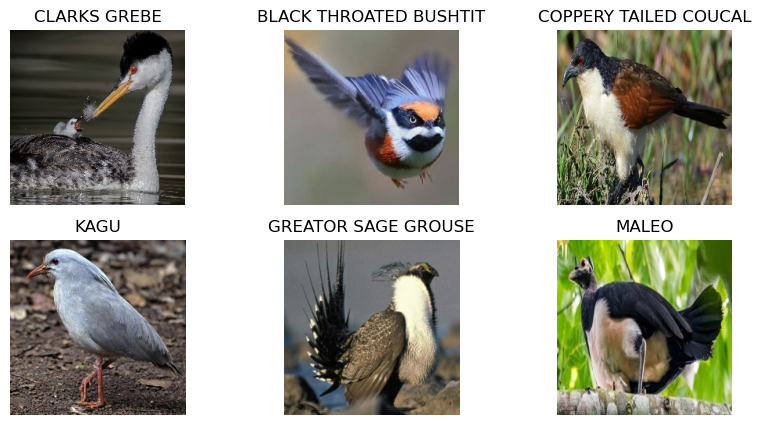

In [20]:
# Let's see a sample of 6 images
plt.figure(figsize=(10, 5))
for i in range(6): 
  # Choose a random image from a random class
  class_name = random.choice(class_names) 
  filename = random.choice(os.listdir(train_dir + "/" + class_name))
  filepath = train_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)

  # plot the images
  plt.subplot(2, 3, i+1)
  plt.imshow(img/255.)
  plt.title(class_name)
  plt.axis(False);

In [21]:
# What is the shape of our data ?
train_data

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 510), dtype=tf.float32, name=None))>

We have a batch of 32 images of shape (224, 224, 3) and labels of 510 classes

## Create model callbacks

In [22]:
# Create ModelCheckpoint callback to save model's progress
checkpoint_path = "/content/drive/MyDrive/Birds/checkpoint/cp.ckpt" # saving weights requires ".ckpt" extension
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0) # don't print out whether or not model is being saved

## Create data augmentation layer

In [23]:
# Create a data augmentation layer to incorporate it right into the model
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import Sequential

# Setup data augmentation
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    # preprocessing.Rescale(1/255.) # Resnet50
],name="data_augmentation")

## Build a feature extraction model

To build the feature extraction model we will use transfer learning with architecture `EfficientNetB0`: https://www.tensorflow.org/api_docs/python/tf/keras/applications/efficientnet/EfficientNetB0

In [24]:
# Setup the base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer")
x = data_augmentation(inputs)
x = base_model(x, training=False) # Put the base model in inference mode so weights need to stay frozen
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)
outputs = layers.Dense(len(class_names), activation="softmax", name="output_layer")(x)
model_1 = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 1s 0us/step


In [25]:
# Get a summary of model we've created
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_avg_pool_layer (Glob  (None, 1280)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 510)               653310    
                                                                 
Total params: 4,702,881
Trainable params: 653,310
Non-trainab

In [26]:
# Compile the model
model_1.compile(loss="categorical_crossentropy", 
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [27]:
# Fit the model and save its history
history_1_extractor = model_1.fit(train_data,
                      epochs=3,
                      steps_per_epoch=len(train_data),
                      validation_data=test_data,
                      validation_steps=int(0.05 * len(test_data)),
                      callbacks=[model_checkpoint])

Epoch 1/3
2522/2522 [==============================] - 2773s 1s/step - loss: 1.4036 - accuracy: 0.7420 - val_loss: 0.5244 - val_accuracy: 0.8906
Epoch 2/3
2522/2522 [==============================] - 1285s 509ms/step - loss: 0.5079 - accuracy: 0.8811 - val_loss: 0.3199 - val_accuracy: 0.9219
Epoch 3/3
2522/2522 [==============================] - 1321s 524ms/step - loss: 0.3830 - accuracy: 0.9059 - val_loss: 0.2589 - val_accuracy: 0.9062


In [28]:
# Evaluate on the whole test dataset
feature_extraction_results = model_1.evaluate(test_data)
feature_extraction_results

80/80 [==============================] - 84s 1s/step - loss: 0.1605 - accuracy: 0.9626


[0.16045084595680237, 0.9625837206840515]

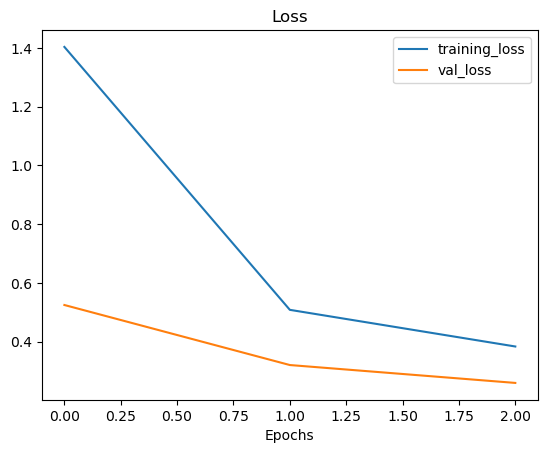

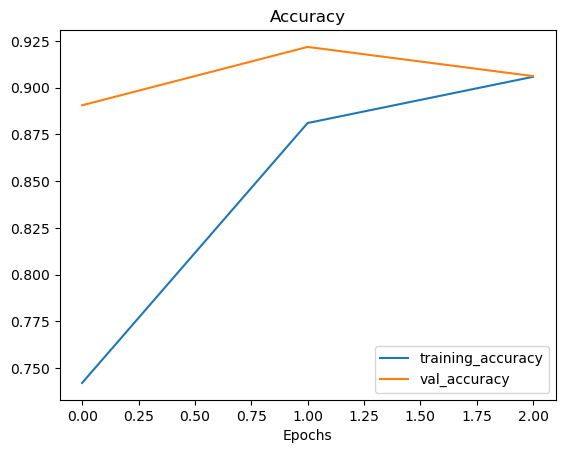

In [29]:
# Plot the loss and accuracy for training and testing
plot_loss_curves(history_1_extractor)

## Fine-tuning

In [30]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layers except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

In [31]:
# Recompile (we have to recompile our models every time we make a change)
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # learning rate dictate how much your model patterns should update to try improve the loss functions
                metrics=["accuracy"])

In [32]:
initial_epoch = 3

In [33]:
# Continue to train and fit the model to our data  
fine_tune_epochs = initial_epoch + 3
history_1_fine = model_1.fit(train_data,
                                      epochs=fine_tune_epochs,
                                      validation_data=test_data,
                                      validation_steps=int(0.05 * len(test_data)),
                                      initial_epoch=history_1_extractor.epoch[-1], 
                                      callbacks=[create_tensorboard_callback(dir_name="drive/MyDrive/Birds/transfer_learning", 
                                                                             experiment_name="Birds")])

Saving TensorBoard log files to: drive/MyDrive/Birds/transfer_learning/Birds/20230520-220132
Epoch 3/6
2522/2522 [==============================] - 1418s 561ms/step - loss: 0.2550 - accuracy: 0.9331 - val_loss: 0.2087 - val_accuracy: 0.9141
Epoch 4/6
2522/2522 [==============================] - 1504s 596ms/step - loss: 0.2083 - accuracy: 0.9438 - val_loss: 0.1989 - val_accuracy: 0.9219
Epoch 5/6
2522/2522 [==============================] - 1599s 634ms/step - loss: 0.1844 - accuracy: 0.9495 - val_loss: 0.1551 - val_accuracy: 0.9375
Epoch 6/6
2522/2522 [==============================] - 1424s 564ms/step - loss: 0.1632 - accuracy: 0.9557 - val_loss: 0.1597 - val_accuracy: 0.9375


In [34]:
# Evaluate on the whole test dataset
fine_tuning_results = model_1.evaluate(test_data)
fine_tuning_results

80/80 [==============================] - 39s 486ms/step - loss: 0.1096 - accuracy: 0.9646


[0.10963425040245056, 0.9645529985427856]

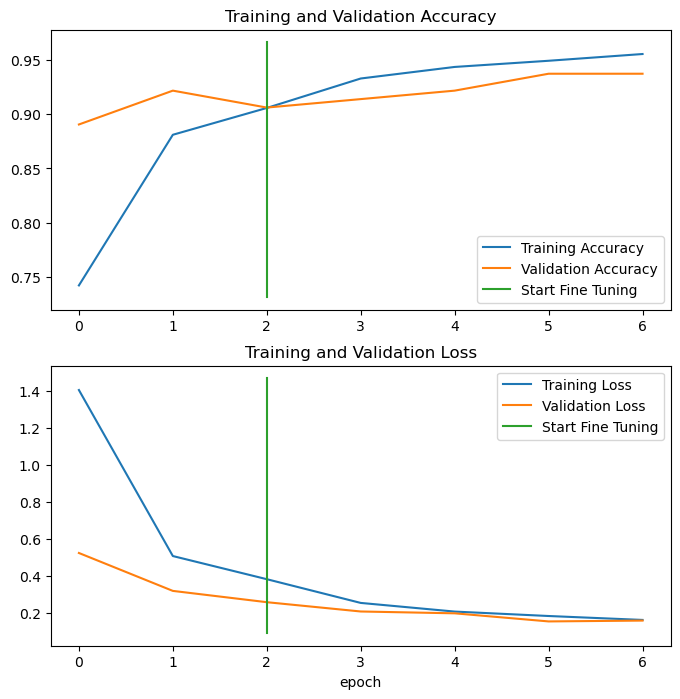

In [35]:
# Compare the histories of feature extration and fine tuning
compare_historys(history_1_extractor,
                 history_1_fine,
                 initial_epoch)

## Making predictions with our trained model

In [39]:
# Calculate the probabilities of the predictions
preds_probs = model_1.predict(test_data, verbose=1) 

80/80 [==============================] - 36s 442ms/step


In [45]:
# Get the pred classes of each labels
pred_classes = preds_probs.argmax(axis=1)

# How do they look ?
pred_classes[:10]

array([  0,   0,   0,   0,   0,   1,   1,   1, 336,   1], dtype=int64)

In [46]:
# To get our test labels we need to unravel our test_data BatchDataseta
y_labels = []
for image, label in test_data.unbatch():
    y_labels.append(label.numpy().argmax())


## Evaluate our predictions by plotting F1-scores histogramme of the differents classes

In [49]:
# Plot the classification report
from sklearn.metrics import classification_report
print(classification_report(y_true=y_labels,
                            y_pred=pred_classes))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       1.00      0.80      0.89         5
           2       1.00      1.00      1.00         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       1.00      0.80      0.89         5
           6       1.00      1.00      1.00         5
           7       1.00      0.80      0.89         5
           8       1.00      1.00      1.00         5
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         5
          11       1.00      1.00      1.00         5
          12       0.83      1.00      0.91         5
          13       1.00      0.80      0.89         5
          14       1.00      1.00      1.00         5
          15       1.00      1.00      1.00         5
          16       1.00      1.00      1.00         5
          17       1.00    

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [51]:
# Get a dictionnary of the classification report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '1': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.888888888888889,
  'support': 5},
 '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '3': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '4': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '5': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.888888888888889,
  'support': 5},
 '6': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '7': {'precision': 1.0,
  'recall': 0.8,
  'f1-score': 0.888888888888889,
  'support': 5},
 '8': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '9': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '10': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '11': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 5},
 '12': {'precision': 0.8333333333333334,
  'recall': 1.0,
  'f1-score': 0.

In [53]:
# Map classes to F1-scores
class_f1_scores = {}
# Loop through classification report dictionnary items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Add class names and f1-scores to new dictionnary
    class_f1_scores[class_names[int(k)]] = v["f1-score"]
class_f1_scores

{'ABBOTTS BABBLER': 1.0,
 'ABBOTTS BOOBY': 0.888888888888889,
 'ABYSSINIAN GROUND HORNBILL': 1.0,
 'AFRICAN CROWNED CRANE': 1.0,
 'AFRICAN EMERALD CUCKOO': 1.0,
 'AFRICAN FIREFINCH': 0.888888888888889,
 'AFRICAN OYSTER CATCHER': 1.0,
 'AFRICAN PIED HORNBILL': 0.888888888888889,
 'AFRICAN PYGMY GOOSE': 1.0,
 'ALBATROSS': 1.0,
 'ALBERTS TOWHEE': 1.0,
 'ALEXANDRINE PARAKEET': 1.0,
 'ALPINE CHOUGH': 0.9090909090909091,
 'ALTAMIRA YELLOWTHROAT': 0.888888888888889,
 'AMERICAN AVOCET': 1.0,
 'AMERICAN BITTERN': 1.0,
 'AMERICAN COOT': 1.0,
 'AMERICAN FLAMINGO': 1.0,
 'AMERICAN GOLDFINCH': 0.8333333333333333,
 'AMERICAN KESTREL': 1.0,
 'AMERICAN PIPIT': 1.0,
 'AMERICAN REDSTART': 0.888888888888889,
 'AMERICAN ROBIN': 1.0,
 'AMERICAN WIGEON': 0.888888888888889,
 'AMETHYST WOODSTAR': 0.7499999999999999,
 'ANDEAN GOOSE': 1.0,
 'ANDEAN LAPWING': 1.0,
 'ANDEAN SISKIN': 0.888888888888889,
 'ANHINGA': 1.0,
 'ANIANIAU': 0.888888888888889,
 'ANNAS HUMMINGBIRD': 1.0,
 'ANTBIRD': 0.888888888888889,
 'ANTI

In [54]:
# Turns f1-scores dictionary into dataframe for visualization
import pandas as pd
f1_scores = pd.DataFrame({"class_names":list(class_f1_scores.keys()),
                         "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores.head()    

class_names  f1-score
0    ABBOTTS BABBLER       1.0
306             KAGU       1.0
318          LIMPKIN       1.0
317     LILAC ROLLER       1.0
316  LESSER ADJUTANT       1.0

(0.0, 1.05)

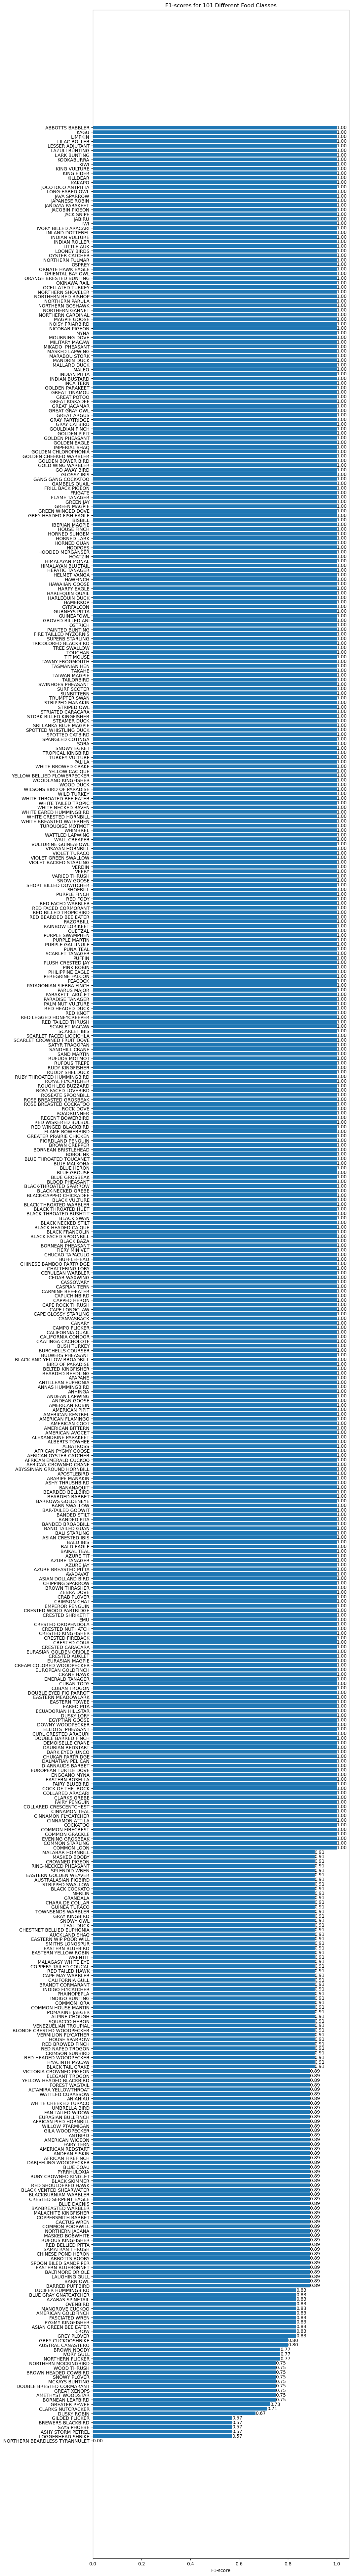

In [58]:
# Plot the F1-scores histogramme from the dataframe
fig, ax = plt.subplots(figsize=(10, 100))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values) 
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(f1_scores["class_names"])
ax.set_xlabel("F1-score")
ax.set_title("F1-scores for 101 Different Food Classes")
ax.invert_yaxis(); 
ax.bar_label(scores, fmt='%.2f')
ax.set_xlim() 
     

## Check the numbers of each classes

In [111]:
# Create a list of classes and their numbers
classes = []
numbers = []
for classe in os.listdir(train_dir):
    classes.append(classe)
    numbers.append(len(os.listdir(train_dir + "/" + classe)))  

In [122]:
# Make it a DataFrame 
birds_num = pd.DataFrame({"Classes":classes,
                 "Number":numbers}).sort_values(by="Number", ascending=False)
birds_num

Classes  Number
279             RUFOUS TREPE     274
252                 OVENBIRD     233
444              HOUSE FINCH     232
57     ASIAN GREEN BEE EATER     220
351        SWINHOES PHEASANT     217
..                       ...     ...
286        ROUGH LEG BUZZARD      96
364  SCARLET FACED LIOCICHLA      90
287      ROSY FACED LOVEBIRD      83
373     VENEZUELIAN TROUPIAL      82
249             MASKED BOOBY      61

[510 rows x 2 columns]

In [119]:
# Check the number of with the fewer F1-scores
birds_num[birds_num["Classes"] == "NORTHERN BEARDLESS TYRANNULET"]

Classes  Number
499  NORTHERN BEARDLESS TYRANNULET     185

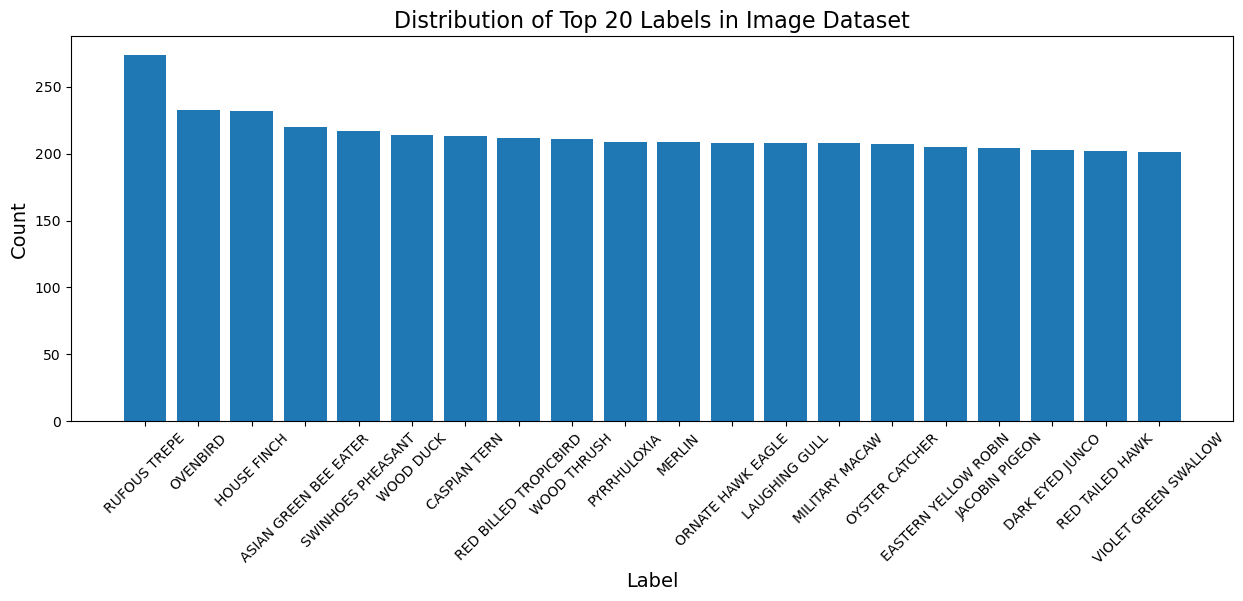

In [147]:
# Plot an histogramme of classes vs numbers
fig, ax = plt.subplots(figsize=(15,5))
ax.bar(birds_num["Classes"][:20],
       birds_num["Number"][:20])
plt.title('Distribution of Top 20 Labels in Image Dataset', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45);

## Visualizing predictions on test images


1/1 [==============================] - 0s 31ms/step


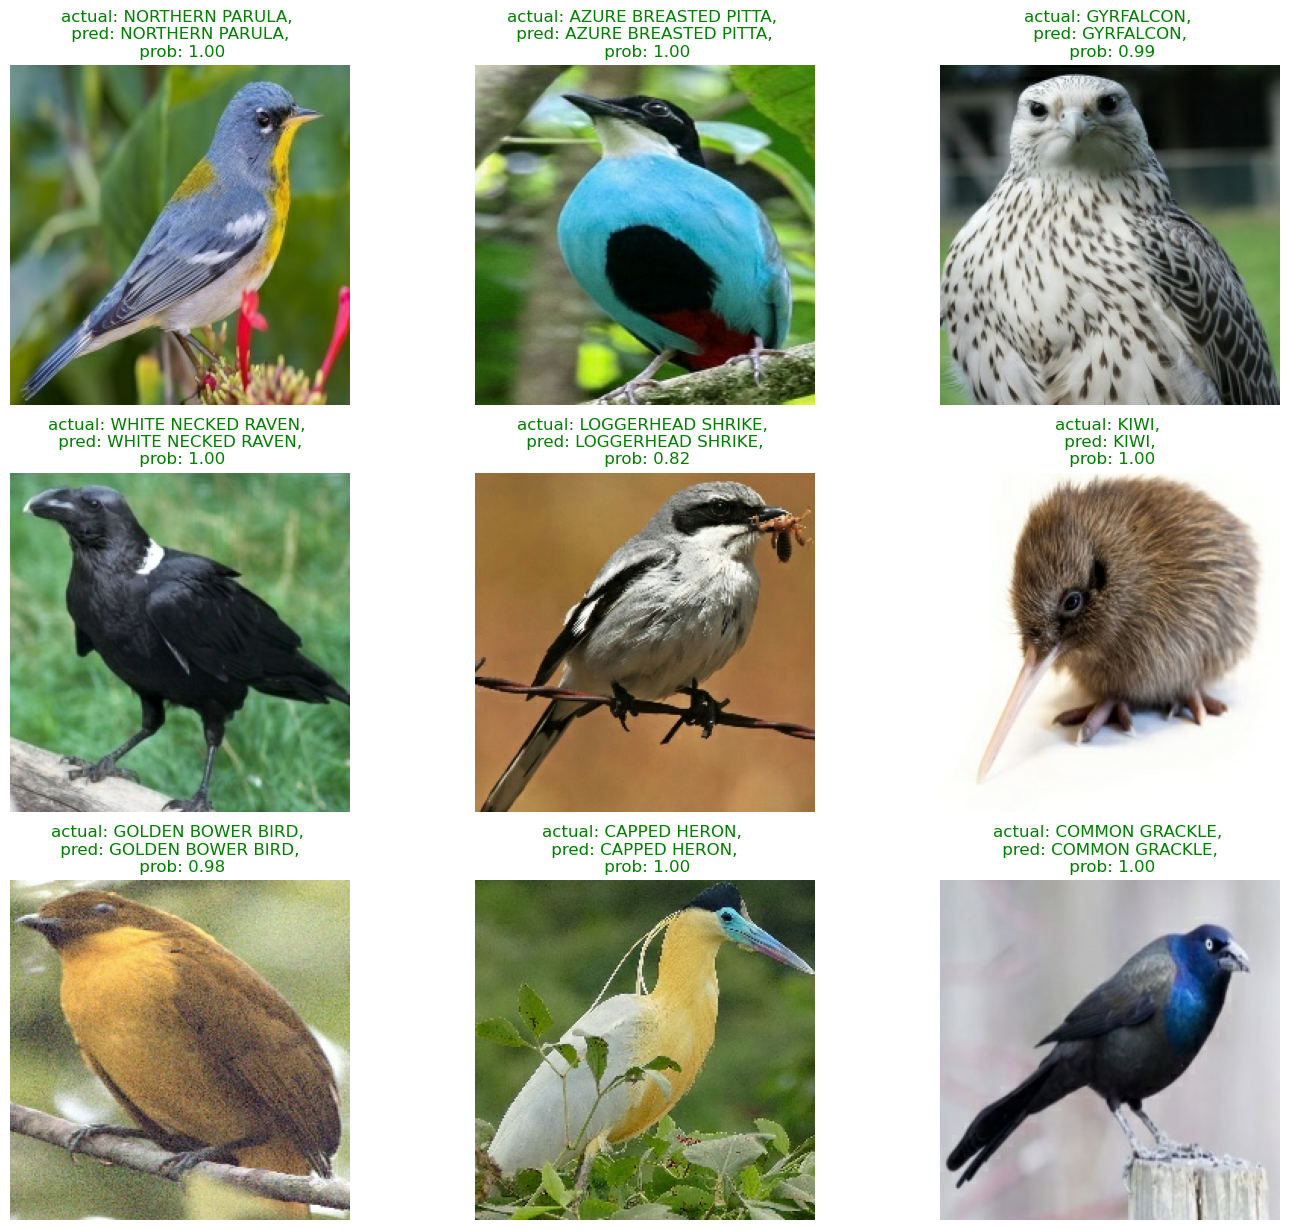

In [105]:
# Make preds on a series of random images
plt.figure(figsize=(17, 15))
for i in range(9): 
  # Choose a random image from a random class
  class_name = random.choice(class_names) 
  filename = random.choice(os.listdir(test_dir + "/" + class_name))
  filepath = test_dir + "/" + class_name + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probility index and match it to class_names list

  # plot the images
  plt.subplot(3, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # if predicted class matches truth class, make test green
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, \n pred: {pred_class}, \n prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False);

## Finding the most wrong predictions

To find out where our model is most wrong, let's write some code to find out the following:

1. Get all of the image file paths in the test dataset using list_files() method.
2. Create a Pandas DataFrame of the image filepaths, ground truth labels, predicted classes (from our model), max predictions probabilities, prediction class names, ground truth class names.
3. Use our DataFrame to find all the wrong predictions (where the ground thruth label doesn't match the prediction).
4. Sort the DataFrame based on wrong predictions (have the highest prediction probability predictions at the top).
5. Visualize the images with the highest prediction probabilities but have the wrong prediction.

In [82]:
# 1. Get all image filepath in test dataset
filepaths = []
for filepath in test_data.list_files("../Google Drive/Mon Drive/Birds/test/*/*", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:5]

[b'..\\Google Drive\\Mon Drive\\Birds\\test\\ABBOTTS BABBLER\\1.jpg',
 b'..\\Google Drive\\Mon Drive\\Birds\\test\\ABBOTTS BABBLER\\2.jpg',
 b'..\\Google Drive\\Mon Drive\\Birds\\test\\ABBOTTS BABBLER\\3.jpg',
 b'..\\Google Drive\\Mon Drive\\Birds\\test\\ABBOTTS BABBLER\\4.jpg',
 b'..\\Google Drive\\Mon Drive\\Birds\\test\\ABBOTTS BABBLER\\5.jpg']

In [83]:
# 2. Create pandas dataframe of differents parameters for each of our test images.
preds_df = pd.DataFrame({"imagepath":filepaths,
                         "y_true":y_labels,
                         "y_pred":pred_classes,
                         "pred_conf":preds_probs.max(axis=1), 
                         "y_true_classname":[class_names[i] for i in y_labels],
                         "y_pred_classname":[class_names[i] for i in pred_classes]})    
preds_df

imagepath  y_true  y_pred  \
0     b'..\\Google Drive\\Mon Drive\\Birds\\test\\AB...       0       0   
1     b'..\\Google Drive\\Mon Drive\\Birds\\test\\AB...       0       0   
2     b'..\\Google Drive\\Mon Drive\\Birds\\test\\AB...       0       0   
3     b'..\\Google Drive\\Mon Drive\\Birds\\test\\AB...       0       0   
4     b'..\\Google Drive\\Mon Drive\\Birds\\test\\AB...       0       0   
...                                                 ...     ...     ...   
2534  b'..\\Google Drive\\Mon Drive\\Birds\\test\\ZE...     509     509   
2535  b'..\\Google Drive\\Mon Drive\\Birds\\test\\ZE...     509     509   
2536  b'..\\Google Drive\\Mon Drive\\Birds\\test\\ZE...     509     509   
2537  b'..\\Google Drive\\Mon Drive\\Birds\\test\\ZE...     509     509   
2538  b'..\\Google Drive\\Mon Drive\\Birds\\test\\ZE...     509     509   

      pred_conf y_true_classname y_pred_classname  
0      0.806661  ABBOTTS BABBLER  ABBOTTS BABBLER  
1      0.979316  ABBOTTS BABBLER  ABBOTTS BABBLER  
2      0.991017  ABBOTTS BABBLER  ABBOTTS BABBLER  
3      0.671101  ABBOTTS BABBLER  ABBOTTS BABBLER  
4      0.997703  ABBOTTS BABBLER  ABBOTTS BABBLER  
...         ...              ...              ...  
2534   0.999936       ZEBRA DOVE       ZEBRA DOVE  
2535   0.998434       ZEBRA DOVE       ZEBRA DOVE  
2536   0.999987       ZEBRA DOVE       ZEBRA DOVE  
2537   0.996997       ZEBRA DOVE       ZEBRA DOVE  
2538   0.999941       ZEBRA DOVE       ZEBRA DOVE  

[2539 rows x 6 columns]

In [103]:
# 3. Find the wrong predictions
preds_df_wrong = preds_df[preds_df["y_true"] != preds_df["y_pred"]]
len(preds_df_wrong)

90

In [86]:
# Sort by the highest probabilites at the top
preds_100_wrong = preds_df_wrong.sort_values("pred_conf", ascending=False)
preds_100_wrong[:5]

imagepath  y_true  y_pred  \
1753  b'..\\Google Drive\\Mon Drive\\Birds\\test\\NO...     352      80   
181   b'..\\Google Drive\\Mon Drive\\Birds\\test\\AS...      36     108   
2100  b'..\\Google Drive\\Mon Drive\\Birds\\test\\RU...     422     386   
306   b'..\\Google Drive\\Mon Drive\\Birds\\test\\BA...      61     440   
1683  b'..\\Google Drive\\Mon Drive\\Birds\\test\\MC...     338     437   

      pred_conf   y_true_classname  y_pred_classname  
1753   0.994013    NORTHERN JACANA  BLACK TAIL CRAKE  
181    0.974145  ASHY STORM PETREL       BROWN NOODY  
2100   0.960009  RUFOUS KINGFISHER  PYGMY KINGFISHER  
306    0.940185           BARN OWL         SNOWY OWL  
1683   0.938494     MCKAYS BUNTING   SMITHS LONGSPUR

In [ ]:
# Save the dataframe just in case
preds_100_wrong.to_csv("drive/MyDrive/Birds/preds_100_wrong")
preds_100_wrong = pd.read_csv("drive/MyDrive/Birds/preds_100_wrong")
preds_100_wrong[:5]

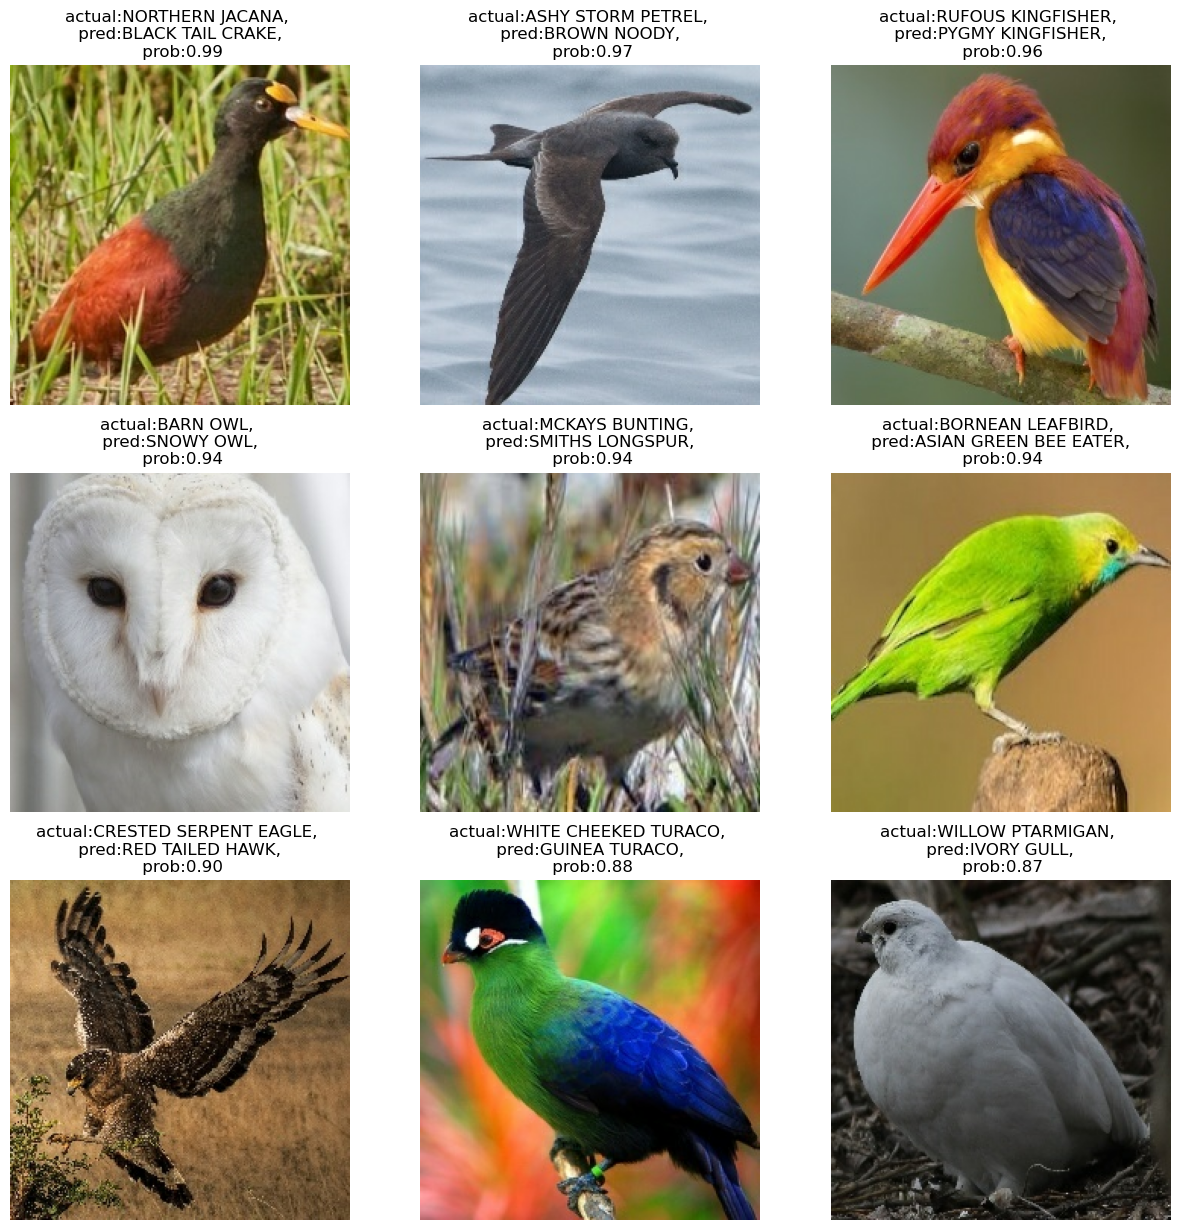

In [101]:
# Plots the 9th first wrong images preds
images_to_view = 9
start_index = 0
plt.figure(figsize=(15,15))
for i, row in enumerate(preds_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=False)
  _, _, _, _, pred_prob, y_true_classname, y_pred_classname = row # only interested in a few parameters of each row
  plt.imshow(img/255.)
  plt.title(f"actual:{y_true_classname}, \n pred:{y_pred_classname}, \n prob:{pred_prob:.2f}")
  plt.axis(False)

## Test out the birds model on our own custom images

In [95]:
# Create custom dir
custom_dir = "../Google Drive/Mon Drive/Birds/custom"

1/1 [==============================] - 0s 33ms/step


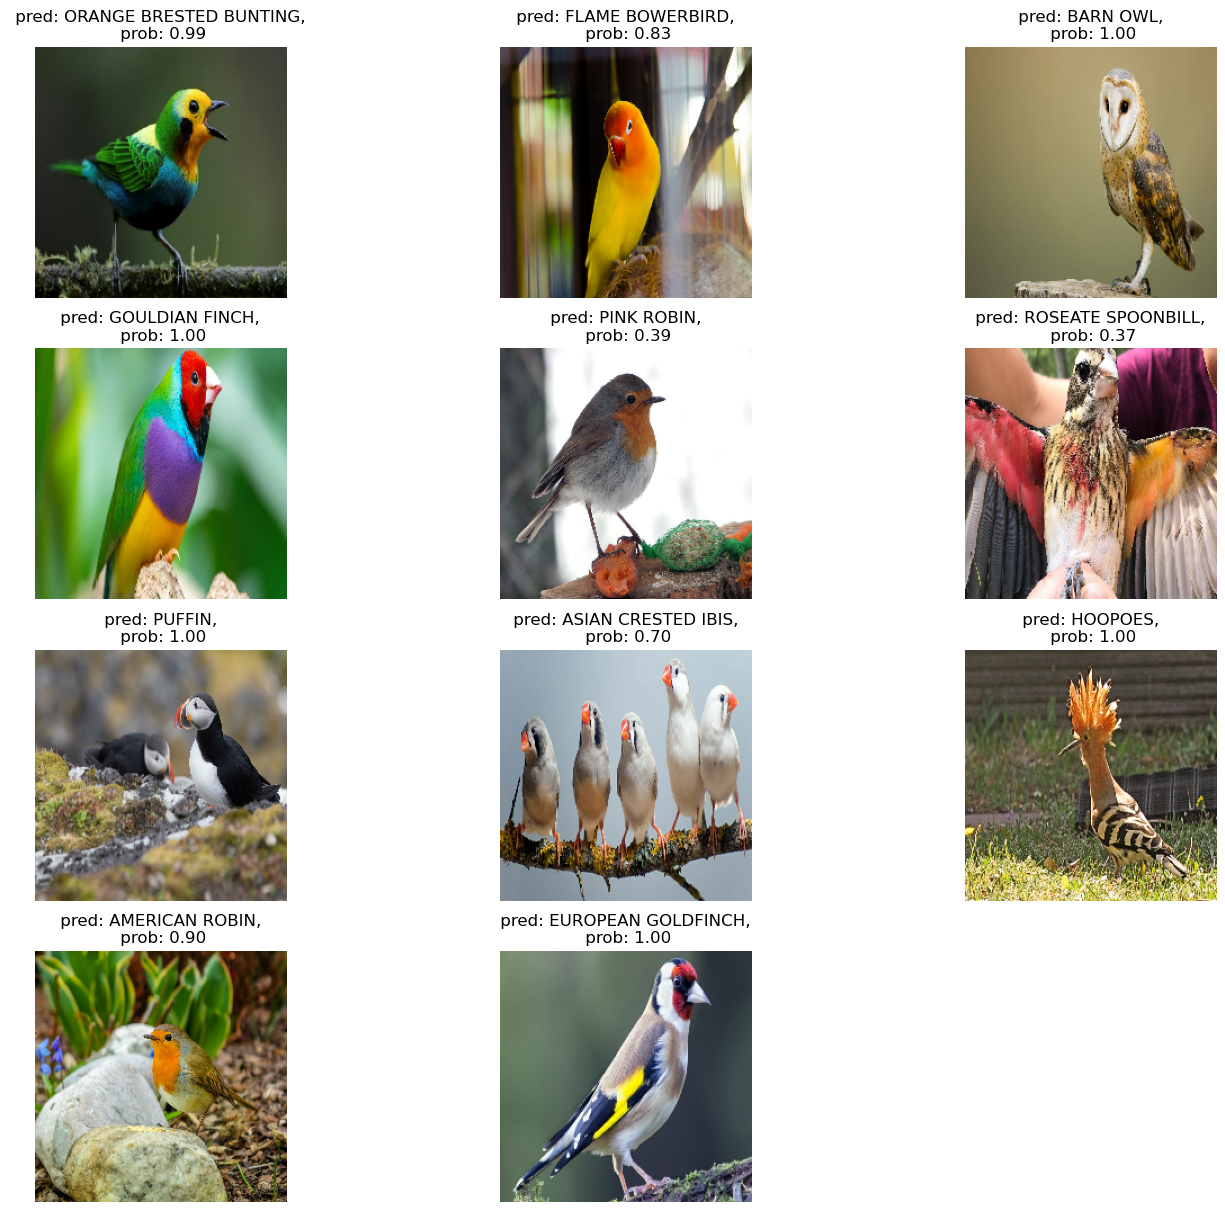

In [104]:
# Plot the predictions on our own images
plt.figure(figsize=(17, 15))
i = 0
for image in os.listdir(custom_dir): 
  # Choose a random image from a random class
  filename = image 
  filepath = custom_dir + "/" + filename

  # Load the image and make predictions
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model_1.predict(tf.expand_dims(img, axis=0)) # get prediction probabilities array
  pred_class = class_names[pred_prob.argmax()] # get highest prediction probility index and match it to class_names list

  # plot the images
  plt.subplot(int(len(os.listdir(custom_dir))/3) + 1, 3, i+1)
  plt.imshow(img/255.)
  plt.title(f" pred: {pred_class}, \n prob: {pred_prob.max():.2f}")
  plt.axis(False);
  i = i + 1